In [1]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [2]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,66782,None,None,86085.715275
2020-06-13,66783,None,None,79940.811469
2020-06-14,66784,None,None,74244.112992
2020-06-15,66785,None,None,68878.187593
2020-06-16,66786,None,None,64137.552455
...,...,...,...,...
2021-06-07,67142,None,None,102642.958929
2021-06-08,67143,None,None,111623.736000
2021-06-09,67144,None,None,121117.036365


In [3]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-06-11_2021-06-11-19-44.pickle


In [4]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-06-10_2021-06-10-16-59.pickle


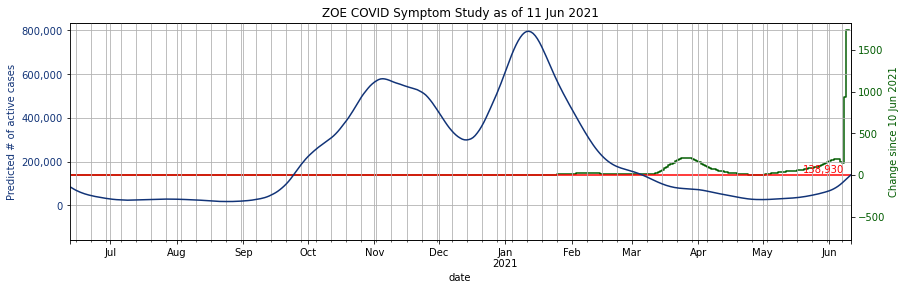

In [5]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

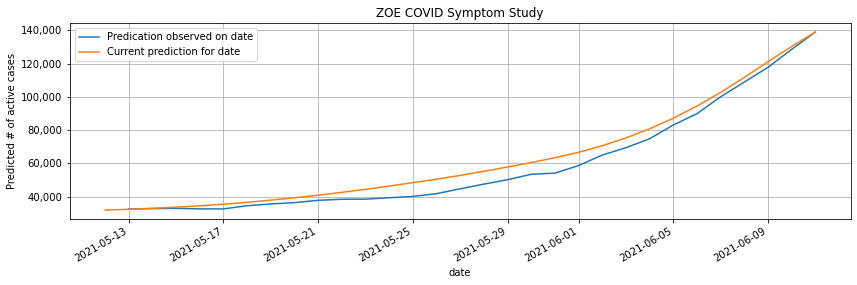

In [6]:
plot_study_evolution(curr_date, days=30)

In [7]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [8]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-06-11_2021-06-11-19-44.pickle


In [9]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
373,North Ayrshire,S12000021,4.388403
269,Rochdale,E08000005,1.795448
266,Bolton,E08000001,1.788228
71,South Derbyshire,E07000039,1.360063
308,Perth and Kinross,S12000024,1.151235
164,Chorley,E07000118,1.142286
244,Nuneaton and Bedworth,E07000219,1.128852
270,Salford,E08000006,1.118260
234,Manchester,E08000003,0.995011
54,Luton,E06000032,0.953632
